Import neccessary packages

In [1]:
import numpy as np
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
import matplotlib.pyplot as plt
from keras.losses import categorical_crossentropy
from sklearn.metrics import confusion_matrix,classification_report
from keras.utils.vis_utils import plot_model
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import pickle
import cv2

Using TensorFlow backend.


In [4]:
#Function to convert images to array
default_image_size = tuple((256, 256))
image_size = 0
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None


#get images from directory
image_list, label_list = [], []
show_image=[]
try:
    print(" Processing Every Folder")
    main_folder = listdir('../input/plantvillage/')
    
    for plant_folder in main_folder :
        disease_folder_list = listdir(f"{'../input/plantvillage/'}/{plant_folder}")
     
        for plant_disease_folder in disease_folder_list:
            print(f" Loding Images From -> {plant_disease_folder} ")
            disease_image_list = listdir(f"{'../input/plantvillage/'}/{plant_folder}/{plant_disease_folder}/")

            for image in disease_image_list[:200]:
                image_directory = f"{'../input/plantvillage/'}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("Image Loading completed  !!")  
except Exception as e:
    print(f"Error : {e}")

 Processing Every Folder
 Loding Images From -> Corn___Northern_Leaf_Blight 
 Loding Images From -> Pepper__bell___Bacterial_spot 
 Loding Images From -> Pepper__bell___healthy 
 Loding Images From -> Potato___Late_blight 
 Loding Images From -> Tomato_Bacterial_spot 
 Loding Images From -> Tomato_Leaf_Mold 
 Loding Images From -> Potato___healthy 
 Loding Images From -> Potato___Early_blight 
 Loding Images From -> Tomato_Late_blight 
 Loding Images From -> Corn___Cercospora_Gray_leaf_spot 
 Loding Images From -> Corn___Common_rust 
Image Loading completed  !!


Transform Image Labels uisng [Scikit Learn](http://scikit-learn.org/)'s LabelBinarizer

In [5]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
# print(image_labels)
n_classes = len(label_binarizer.classes_)


In [7]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [8]:
print("Spliting data to train and test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [9]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [10]:
model = Sequential()

#first layer conv
model.add(Conv2D(32, (3, 3), padding="same",input_shape=256,256,3))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

#2nd layer conv 
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=1))

#3rd layer conv 
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#4th layer conv
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=1))

#5th layer conv 
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#fully connected layer 
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

Model Summary

In [11]:
# # Compile the model
# model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

In [12]:
opt = Adam(lr=1e-3, decay=1e-3 / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

In [13]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

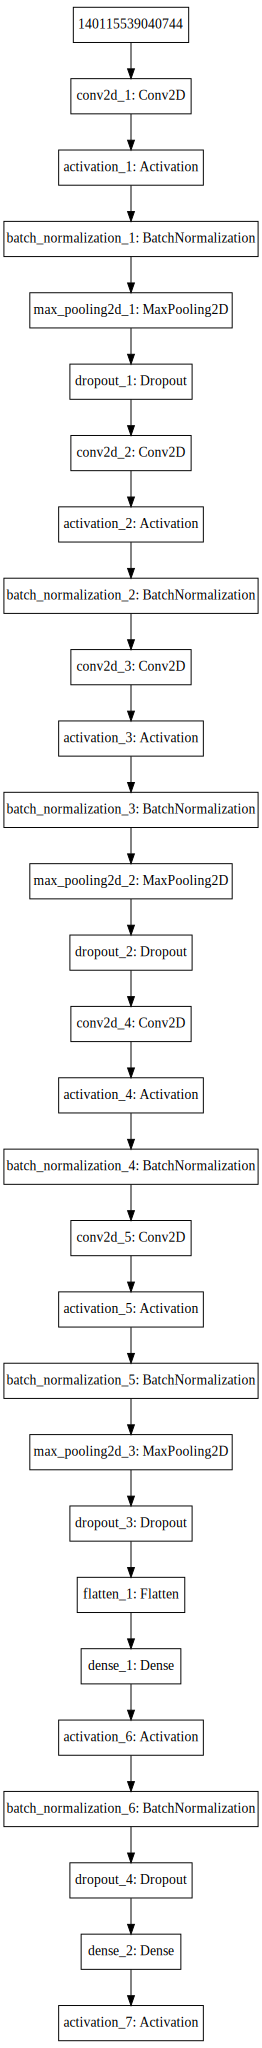

In [14]:
SVG(model_to_dot(model).create(prog='dot',format='svg'))

In [15]:
EPOCHS = 25
BS = 32
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/25
53/53 [==============================] - 31s 593ms/step - loss: 0.2360 - acc: 0.9216 - val_loss: 0.2452 - val_acc: 0.9311
Epoch 2/25
53/53 [==============================] - 22s 417ms/step - loss: 0.2008 - acc: 0.9313 - val_loss: 1.4690 - val_acc: 0.8501
Epoch 3/25
53/53 [==============================] - 23s 425ms/step - loss: 0.1568 - acc: 0.9456 - val_loss: 0.2895 - val_acc: 0.9214
Epoch 4/25
53/53 [==============================] - 22s 422ms/step - loss: 0.1361 - acc: 0.9507 - val_loss: 0.5357 - val_acc: 0.9036
Epoch 5/25
53/53 [==============================] - 22s 419ms/step - loss: 0.1354 - acc: 0.9530 - val_loss: 0.2626 - val_acc: 0.9345
Epoch 6/25
53/53 [==============================] - 22s 419ms/step - loss: 0.1170 - acc: 0.9585 - val_loss: 0.4257 - val_acc: 0.9188
Epoch 7/25
53/53 [==============================] - 22s 420ms/step - loss: 0.1058 - acc: 0.9620 - val_loss: 0.7324 - val_acc: 0.8945
Epoch 8/25
53/53 [==============================] - 23s 436ms/step - 

Plot the train and val curve

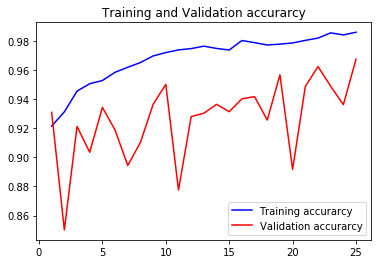

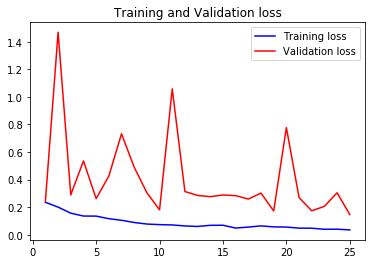

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Model Accuracy

In [17]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
430/430 [==============================] - 1s 2ms/step
Test Accuracy: 96.7653273981671


In [18]:
predictions = model.predict(x_test,verbose=1)

430/430 [==============================] - 1s 3ms/step


In [19]:
from sklearn.metrics import confusion_matrix
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test2 = np.argmax(y_test,axis=1)

cm = confusion_matrix(y_test2,pred)
np.set_printoptions(precision=2)
print(cm)
plt.figure()

[[40  0  4  0  0  1  0  0  0  0  0]
 [ 0 38  0  0  0  0  0  0  0  0  0]
 [ 6  0 29  0  0  0  0  0  0  0  0]
 [ 0  0  0 21 17  0  0  3  0  0  0]
 [ 0  0  0  0 43  0  0  2  0  0  0]
 [ 0  0  0  0  1 39  0  1  0  0  0]
 [ 0  0  0  0  0  9 14  9  0  0  0]
 [ 0  0  0  0  1  0  0 29  0  0  0]
 [ 0  0  0  0  2  0  0  0 42  0  0]
 [ 0  0  0  0  1  7  2  2  0 25  0]
 [ 0  0  0  0  6  3  0  0  0  1 32]]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

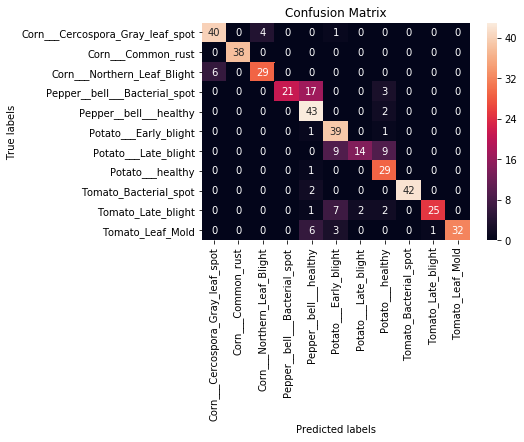

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt 

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(label_binarizer.classes_,rotation=90); ax.yaxis.set_ticklabels(label_binarizer.classes_,rotation=0);

In [ ]:
print(confusion_matrix.classification_report(y_test, y_pred))

Save model using Pickle

In [21]:
# save the model to disk
print("[INFO] Saving model...")
model.save('mymodel.h5')

[INFO] Saving model...
